In [1]:
import pandas as pd
df1 = pd.read_csv("df1_preprocessed.csv")
df2 = pd.read_csv("df2_preprocessed.csv")

In [2]:
df3 = df1.drop(columns = ['suicides_no', 'country-year']).copy()
cols_to_keep = ['year', 'age', 'suicides/100k pop', 'sex', 'race', 'hispanic']
df2_filtered = df2.loc[~df2["STUB_NAME_NUM"].isin([0, 1]), cols_to_keep]
df2_filtered['country'] = 'United States'
df3 = pd.concat([df3, df2_filtered], ignore_index = True)

In [3]:
df3["country"] = df3["country"].astype(str).str.strip().str.title()
df3 = df3.sort_values(by = ['country', 'year'], ascending = [True, True]).reset_index(drop = True)

In [4]:
#Match missing "gdp_for_year ($)", "HDI for year", "gdp_per_capita ($)" values
pop_lookup = (
    df3.loc[df3["gdp_for_year ($)"].notna(), ["country", "year", "gdp_for_year ($)", "HDI for year", "gdp_per_capita ($)"]]
        .drop_duplicates(subset = ["country", "year"])
)

df3 = df3.merge(
    pop_lookup,
    on = ["country", "year"],
    how = "left",
    suffixes = ("", "_lookup")
)

for col in ["gdp_for_year ($)", "HDI for year", "gdp_per_capita ($)"]:
    df3[col] = df3[col].fillna(df3[f"{col}_lookup"])
df3 = df3.drop(columns=[f"{col}_lookup" for col in ["gdp_for_year ($)", "HDI for year", "gdp_per_capita ($)"]])

pop_lookup.to_csv("pop_lookup.csv", index = False)

In [5]:
gen_lookup = df1[["year", "age", "generation"]].drop_duplicates()

df3 = df3.merge(
    gen_lookup,
    on = ["year", "age"],
    how = "left",
    suffixes = ("", "_df1")
)

df3["generation"] = df3["generation"].fillna(df3["generation_df1"])
df3 = df3.drop(columns = ["generation_df1"])

In [6]:
age_mapping = {
    '5-14 years': ['10-14 years'],
    '15-24 years': ['15-19 years', '20-24 years'],
    '35-54 years': ['35-44 years', '45-54 years'],
    '55-74 years': ['55-64 years', '65 years and over', '65-74 years'],
    '75+ years': ['75-84 years','85 years and over']
}
gen_lookup_2 = df1[['year', 'age', 'generation']].drop_duplicates()

expanded_rows = []

for base_age, sub_ages in age_mapping.items():
    gen_rows = gen_lookup_2[gen_lookup_2["age"] == base_age]
    for _, row in gen_rows.iterrows():
        for sub_age in sub_ages:
            expanded_rows.append({
                "year": row["year"],
                "age": sub_age,
                "generation": row["generation"]
            })

expanded_lookup = pd.DataFrame(expanded_rows)
final_lookup = pd.concat([gen_lookup, expanded_lookup], ignore_index=True).drop_duplicates(subset=["year", "age"])
df3 = df3.merge(
    final_lookup,
    on=["year", "age"],
    how="left",
    suffixes=("", "_df1")
)

# Fill generation for missing ones
df3["generation"] = df3["generation"].fillna(df3["generation_df1"])
df3 = df3.drop(columns=["generation_df1"])


In [7]:
hispanic_countries = {
    'Argentina': 'Y',
    'Belize': 'Y',
    'Chile': 'Y',
    'Colombia': 'Y',
    'Costa Rica': 'Y',
    'Cuba': 'Y',
    'Ecuador': 'Y',
    'El Salvador': 'Y',
    'Guatemala': 'Y',
    'Mexico': 'Y',
    'Nicaragua': 'Y',
    'Panama': 'Y',
    'Paraguay': 'Y',
    'Puerto Rico': 'Y',
    'Spain': 'Y',
    'Uruguay': 'Y'
}
# Fill only where 'hispanic' is null
mask = df3["hispanic"].isna()

df3.loc[mask, "hispanic"] = (
    df3.loc[mask, "country"]
    .apply(lambda c: hispanic_countries.get(c, None) if c == "United States" else hispanic_countries.get(c, "N"))
)

In [8]:
df3 = df3[~((df3["country"] == "United States") & (df3["year"] <= 1984))]
df3 = df3[df3["suicides/100k pop"].notna()]

In [9]:
race_country_map = {
    "White": [
        "Albania", "Armenia", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina",
        "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia",
        "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland",
        "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Montenegro",
        "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Russian Federation",
        "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Ukraine",
        "San Marino"
    ],

    "Black or African American": [
        "Bahamas", "Barbados", "Belize", "Cabo Verde", "Dominica", "Grenada",
        "Guyana", "Jamaica", "Saint Kitts and Nevis", "Saint Lucia",
        "Saint Vincent and Grenadines", "Suriname", "Trinidad and Tobago"
    ],
    
    "Asian": [
        "Japan", "Kazakhstan", "Kuwait", "Kyrgyzstan", "Maldives", "Mongolia",
        "Philippines", "Qatar", "Republic of Korea", "Singapore", "Sri Lanka",
        "Thailand", "Turkey", "Turkmenistan", "United Arab Emirates", "Uzbekistan"
    ],

    "Native Hawaiian or Other Pacific Islander": [
        "Fiji", "Kiribati"
    ]
}
# Fill null "race" values using the country-to-race mapping
def map_country_to_race(country):
    for race, countries in race_country_map.items():
        if country in countries:
            return race
    return None  # leave as NaN if no match

mask = df3["race"].isna()
df3.loc[mask, "race"] = df3.loc[mask, "country"].apply(map_country_to_race)


In [10]:
df3.to_csv("output.csv", index = False)

In [13]:
suicides_filtered = df3.loc[~((df3["suicides/100k pop"] == 0) & (df3["population"] >= 10000)), "suicides/100k pop"]

suicides_nonzero = df3.loc[df3["suicides/100k pop"] > 0, "suicides/100k pop"]

def print_stats(series, label):
    mean_val = series.mean()
    median_val = series.median()
    mode_val = series.mode().iloc[0] if not series.mode().empty else np.nan
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    min_val = series.min()
    max_val = series.max()
    range_val = max_val - min_val
    variance_val = series.var()
    std_dev_val = series.std()
    
    print(f"\nSuicide per 100k pop. descriptive statistics for {label}:")
    print(f"Mean: {mean_val:.2f}")
    print(f"Median (Q2): {median_val:.2f}")
    print(f"Mode: {mode_val:.2f}")
    print(f"Q1 (25th percentile): {q1:.2f}")
    print(f"Q3 (75th percentile): {q3:.2f}")
    print(f"Min: {min_val:.2f}")
    print(f"Max: {max_val:.2f}")
    print(f"Range: {range_val:.2f}")
    print(f"Variance: {variance_val:.2f}")
    print(f"Standard Deviation: {std_dev_val:.2f}")

print_stats(df3['suicides/100k pop'], 'all values')

print_stats(suicides_filtered, "filtered zeroes")
print_stats(suicides_nonzero, "nonzeroes")
print("Data Overview: \n")
print(df3.head())
print("\nData Count: \n")
print(df3.count())


Suicide per 100k pop. descriptive statistics for all values:
Mean: 12.89
Median (Q2): 6.54
Mode: 0.00
Q1 (25th percentile): 1.38
Q3 (75th percentile): 17.17
Min: 0.00
Max: 224.97
Range: 224.97
Variance: 330.43
Standard Deviation: 18.18

Suicide per 100k pop. descriptive statistics for filtered zeroes:
Mean: 14.09
Median (Q2): 7.72
Mode: 0.00
Q1 (25th percentile): 2.43
Q3 (75th percentile): 18.73
Min: 0.00
Max: 224.97
Range: 224.97
Variance: 344.31
Standard Deviation: 18.56

Suicide per 100k pop. descriptive statistics for nonzeroes:
Mean: 14.87
Median (Q2): 8.49
Mode: 0.29
Q1 (25th percentile): 3.17
Q3 (75th percentile): 19.72
Min: 0.02
Max: 224.97
Range: 224.95
Variance: 351.76
Standard Deviation: 18.76
Data Overview: 

   country  year     sex          age  population  suicides/100k pop  \
0  Albania  1987    male  15-24 years    312900.0               6.71   
1  Albania  1987    male  35-54 years    308000.0               5.19   
2  Albania  1987  female  15-24 years    289700.0   

/var/folders/49/71rbt9z16wn35ld6v0kz4pd80000gn/T/ipykernel_16304/3706746893.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df3, x="generation", y="suicides/100k pop", palette="Blues_d", ci=None)
/var/folders/49/71rbt9z16wn35ld6v0kz4pd80000gn/T/ipykernel_16304/3706746893.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df3, x="generation", y="suicides/100k pop", palette="Blues_d", ci=None)


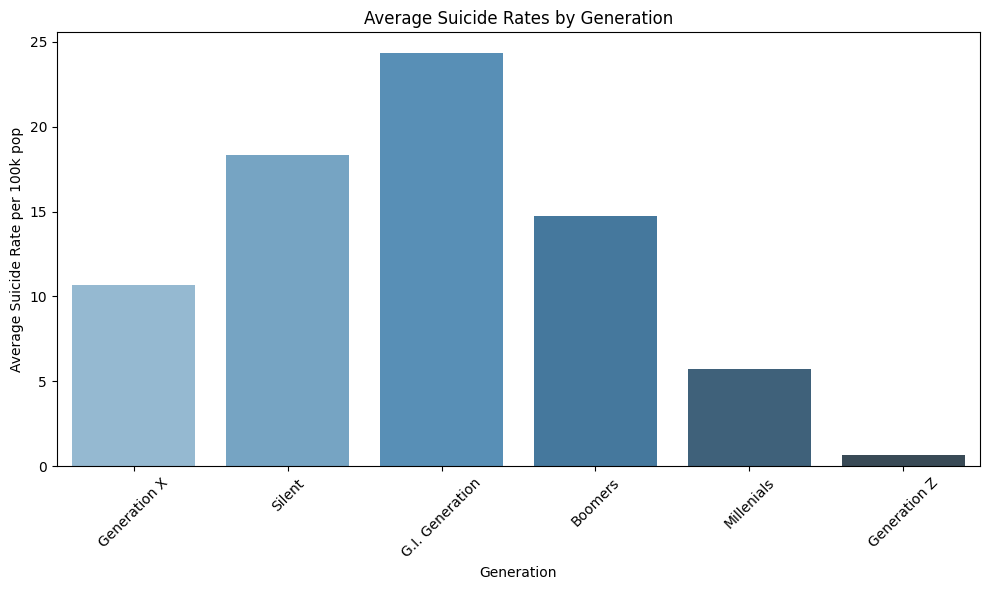

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=df3, x="generation", y="suicides/100k pop", palette="Blues_d", ci=None)
plt.ylabel("Average Suicide Rate per 100k pop")
plt.xlabel("Generation")
plt.title("Average Suicide Rates by Generation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


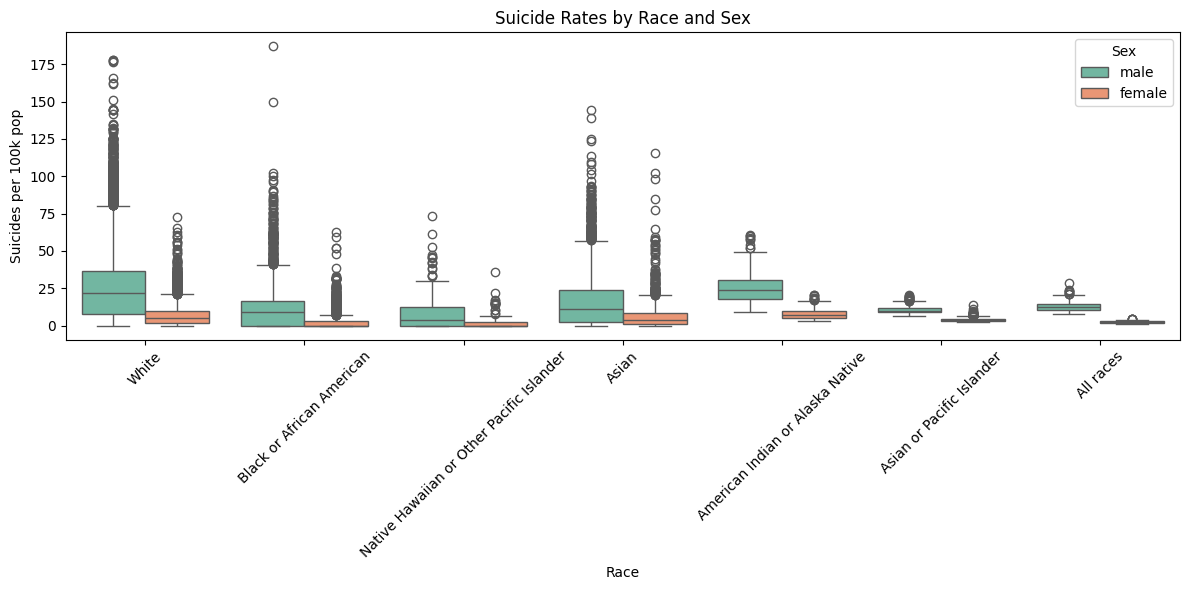

In [16]:


plt.figure(figsize=(12,6))
sns.boxplot(
    data=df3,
    x="race",
    y="suicides/100k pop",
    hue="sex",            # separate by sex
    palette="Set2"
)

plt.ylabel("Suicides per 100k pop")
plt.xlabel("Race")
plt.title("Suicide Rates by Race and Sex")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()


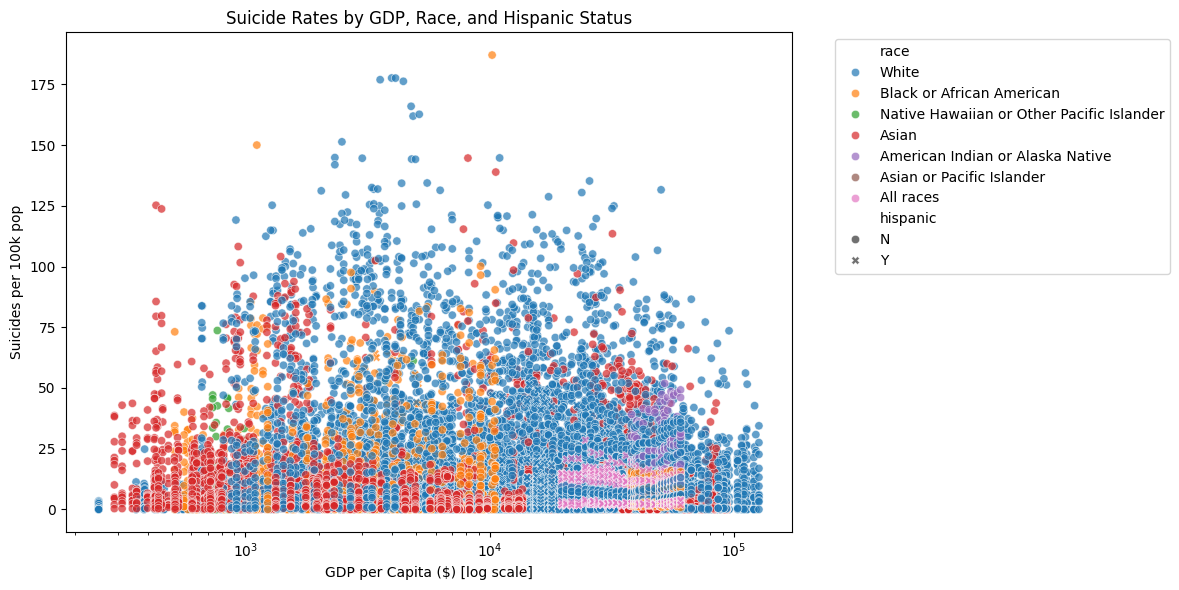

In [17]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df3,
    x="gdp_per_capita ($)",
    y="suicides/100k pop",
    hue="race",       # color by race
    style="hispanic", # different markers for hispanic/non-hispanic
    alpha=0.7
)

plt.xscale("log")  # GDP is usually skewed
plt.xlabel("GDP per Capita ($) [log scale]")
plt.ylabel("Suicides per 100k pop")
plt.title("Suicide Rates by GDP, Race, and Hispanic Status")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/49/71rbt9z16wn35ld6v0kz4pd80000gn/T/ipykernel_16304/2481362698.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


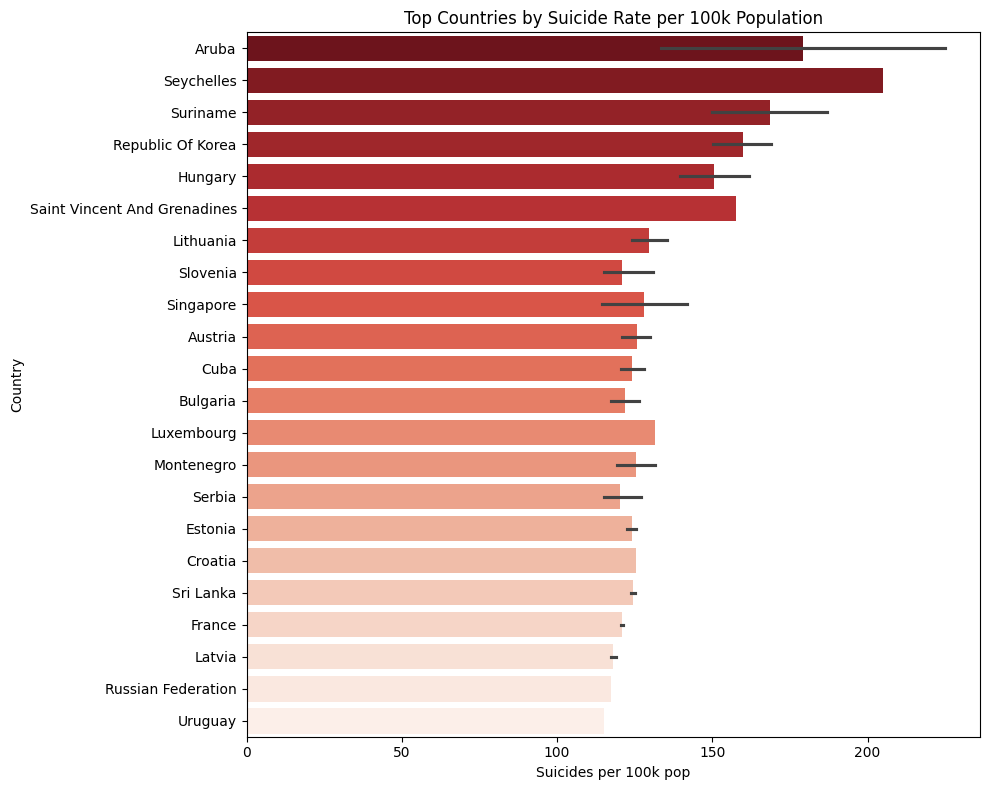

In [24]:

# Filter out rows with nulls in key columns
df_filtered = df3.dropna(subset=['suicides/100k pop', 'country'])

# Get top 20 countries by suicide rate
top20 = df_filtered.sort_values(by="suicides/100k pop", ascending=False).head(100)

plt.figure(figsize=(10,8))
sns.barplot(
    data=top20,
    y="country", 
    x="suicides/100k pop",
    palette="Reds_r"
)

plt.xlabel("Suicides per 100k pop")
plt.ylabel("Country")
plt.title("Top Countries by Suicide Rate per 100k Population")
plt.tight_layout()
plt.show()



/var/folders/49/71rbt9z16wn35ld6v0kz4pd80000gn/T/ipykernel_16304/2290297339.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


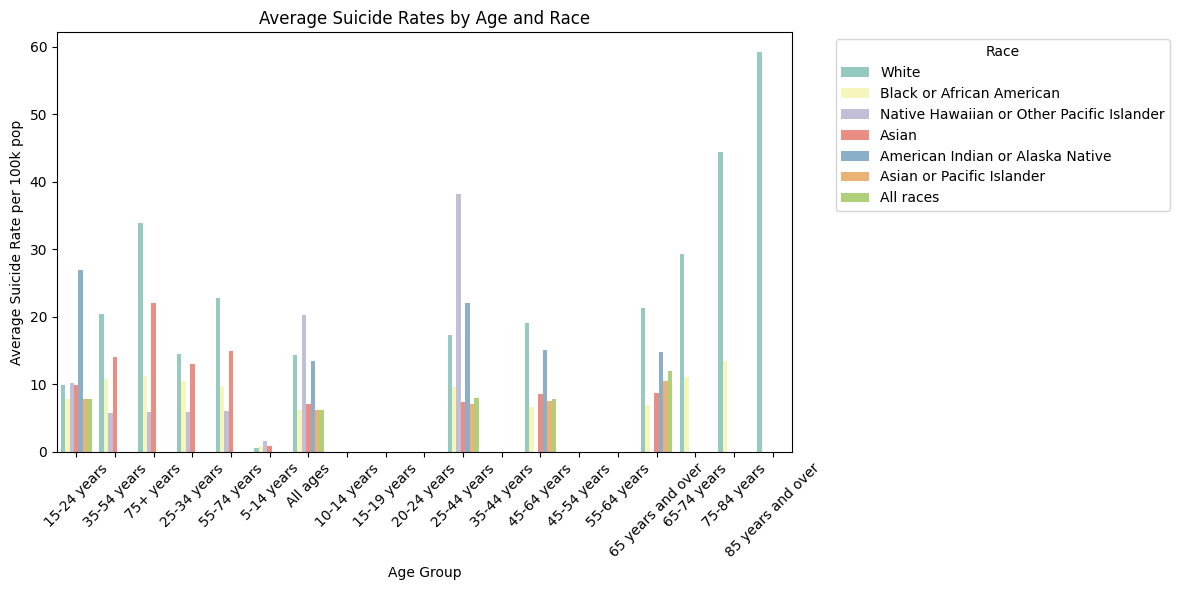

In [25]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df3,
    x="age",
    y="suicides/100k pop",
    hue="race",
    palette="Set3",
    ci=None  # no confidence intervals
)

plt.ylabel("Average Suicide Rate per 100k pop")
plt.xlabel("Age Group")
plt.title("Average Suicide Rates by Age and Race")
plt.xticks(rotation=45)
plt.legend(title="Race", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


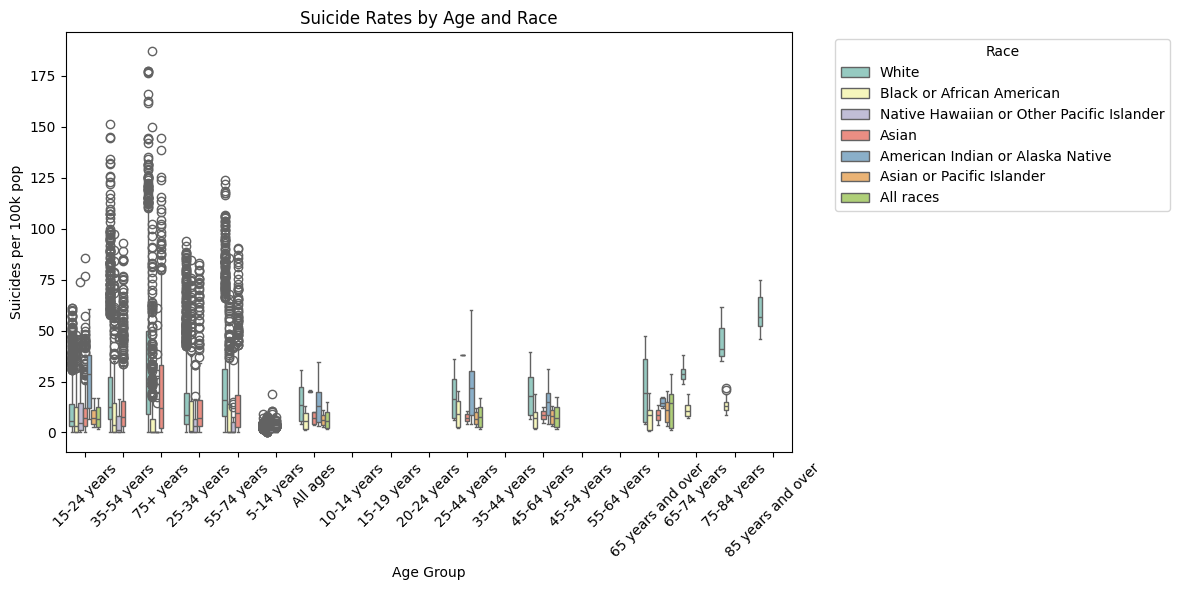

In [26]:

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df3,
    x="age",
    y="suicides/100k pop",
    hue="race",
    palette="Set3"
)

plt.ylabel("Suicides per 100k pop")
plt.xlabel("Age Group")
plt.title("Suicide Rates by Age and Race")
plt.xticks(rotation=45)
plt.legend(title="Race", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/49/71rbt9z16wn35ld6v0kz4pd80000gn/T/ipykernel_16304/2919420192.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


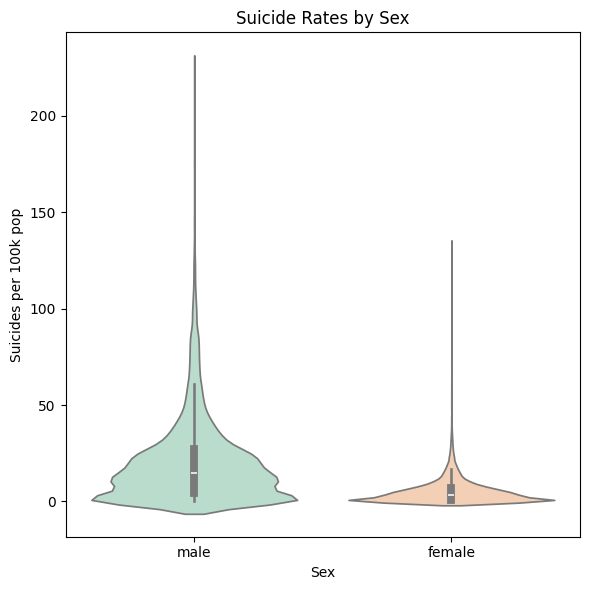

In [27]:
plt.figure(figsize=(6,6))
sns.violinplot(
    data=df3,
    x="sex",
    y="suicides/100k pop",
    palette="Pastel2"
)

plt.ylabel("Suicides per 100k pop")
plt.xlabel("Sex")
plt.title("Suicide Rates by Sex")
plt.tight_layout()
plt.show()


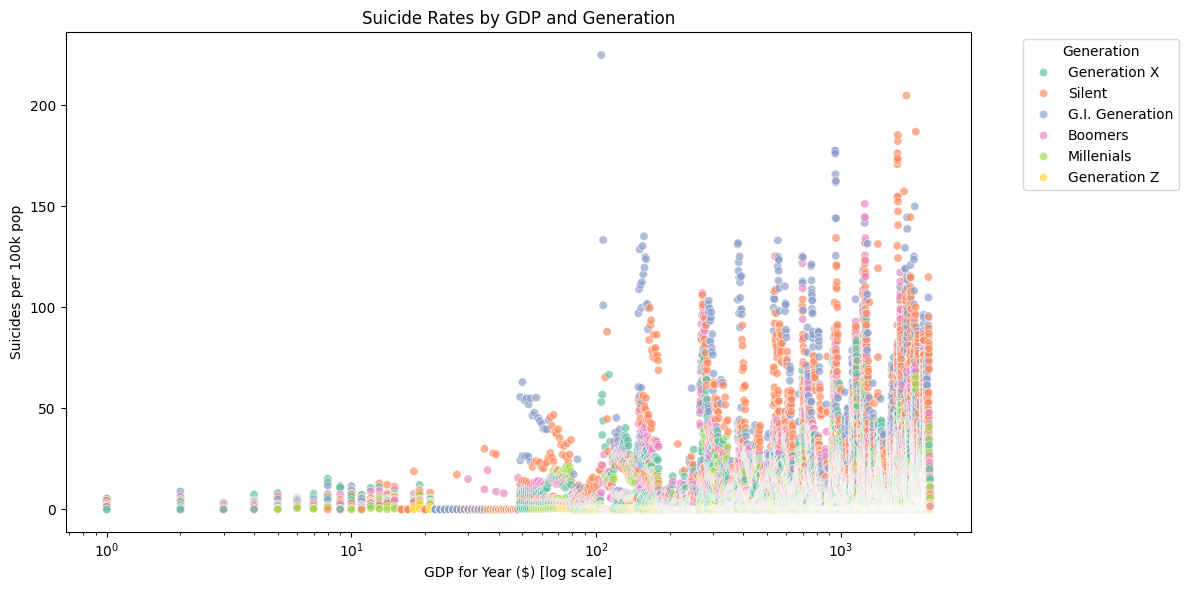

In [29]:

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df3,
    x="gdp_for_year ($)",
    y="suicides/100k pop",
    hue="generation",
    palette="Set2",
    alpha=0.7
)

plt.xscale("log")  # GDP is often skewed
plt.xlabel("GDP for Year ($) [log scale]")
plt.ylabel("Suicides per 100k pop")
plt.title("Suicide Rates by GDP and Generation")
plt.legend(title="Generation", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
